# What Makes an Online Video go Viral?

## Context
YouTube (the world-famous video sharing website) maintains a list of the top trending videos on the platform. According to Variety magazine, “To determine the year’s top-trending videos, YouTube uses a combination of factors including measuring users interactions (number of views, shares, comments and likes). Note that they’re not the most-viewed videos overall for the calendar year”. Top performers on the YouTube trending list are music videos (such as the famously virile “Gangam Style”), celebrity and/or reality TV performances, and the random dude-with-a-camera viral videos that YouTube is well-known for.

This dataset is a daily record of the top trending YouTube videos.

Note that this dataset is a structurally improved version of this dataset.


## Content
This dataset includes several months (and counting) of data on daily trending YouTube videos. Data is included for the US, GB, DE, CA, and FR regions (USA, Great Britain, Germany, Canada, and France, respectively), with up to 200 listed trending videos per day.

Each region’s data is in a separate file. Data includes the video title, channel title, publish time, tags, views, likes and dislikes, description, and comment count.

The data also includes a category_id field, which varies between regions. To retrieve the categories for a specific video, find it in the associated JSON. One such file is included for each of the five regions in the dataset.

For more information on specific columns in the dataset refer to the column metadata.


## Acknowledgements
* This dataset was collected using the YouTube API.

## Inspiration
Possible uses for this dataset could include:

* Sentiment analysis in a variety of forms
* Categorising YouTube videos based on their comments and statistics.
* Training ML algorithms like RNNs to generate their own YouTube comments.
* Analysing what factors affect how popular a YouTube video will be.
* Statistical analysis over time.


[note] - This dataset, as well as the above description was adapted from: https://www.kaggle.com/datasnaek/youtube-new

## Exploratory Data Analysis (EDA)

---

### Library Imports

In [43]:
# IMPORTS

# meta
import progressbar
import pprint

# general
import re
from collections import Counter
import calendar
from itertools import combinations
import string

# server requests
import json, requests

# datastructures
import pandas as pd
import numpy as np
import json

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
from matplotlib import cm
from matplotlib import collections as mc

# statistics and ml
import random
from scipy import stats
from textblob import TextBlob
import statsmodels.formula.api as sm


# settings
%matplotlib inline
plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = (10, 10)

### Reading the Data

In [3]:
# we'll begin our exploration with the US dataset
file_path = '../data/youtube_trending/USvideos.csv'
trending_df = pd.read_csv(file_path, dtype={'category_id': np.int8, 'views': np.int64, 
                                            'likes': np.int64, 'dislikes': np.int64, 
                                            'comment_count': np.int64})
trending_df.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...


### Cleaning the Data

#### Processing Dates

Lets convert `trending_date`, and `publish_time` into datetime datastructures.

In [4]:
trending_df['trending_date'] = pd.to_datetime(trending_df['trending_date'], format='%y.%d.%m')
trending_df['publish_time'] = pd.to_datetime(trending_df['publish_time'], format='%Y-%m-%dT%H:%M:%S.%fZ')

#### Adding Catagory Types

The `catagory_id` is just a mapping to the catagories identified within the `US_category_id.json` file. Lets add this into our dataframe, as it will simplify things in the future.

In [5]:
# map catagory id to catagory type
with open('../data/youtube_trending/US_category_id.json', 'r') as f:
    data = json.load(f)
    id_to_category = {int(category['id']): category['snippet']['title'] for category in data['items']}

trending_df.insert(4, 'category', trending_df['category_id'].map(id_to_category))

#### Adding Number of Tags

While we know what the tags are, perhaps their frequency can tell us something.

In [6]:
n_tags = [len(list(filter(lambda token: token!='', re.split('"|\|', tag)))) for tag in trending_df['tags']]
trending_df.insert(8, 'n_tags', n_tags)

#### Removing Duplicate Videos

Because this data set has been aggregated daily over time, there is an almost guarenteed chance that at least one video has trended for multiple days and therefore appears at least more than once within the dataset.


In [7]:
dup_trending_df = trending_df
trending_df = trending_df[~trending_df.index.duplicated(keep='last')]
trending_df.head()

,video_id,trending_date,title,channel_title,category,category_id,publish_time,tags,n_tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,People & Blogs,22,2017-11-13 17:13:01,SHANtell martin,1,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,2017-11-14,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,Entertainment,24,2017-11-13 07:30:00,"last week tonight trump presidency|""last week ...",4,2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,2017-11-14,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,Comedy,23,2017-11-12 19:05:24,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",23,3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,2017-11-14,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,Entertainment,24,2017-11-13 11:00:04,"rhett and link|""gmm""|""good mythical morning""|""...",27,343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,2017-11-14,I Dare You: GOING BALD!?,nigahiga,Entertainment,24,2017-11-12 18:01:41,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",14,2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...


### Filling In Missing Values

Sometimes the description of a video is empty. Because we will later want to do some processing on this column, we will fill missing values as an empty string.

In [8]:
trending_df['description'] = trending_df['description'].fillna('')

### Save Cleaned Data

Now that we have cleaned our dataset for the most part, lets save the new file for safekeeping.

In [34]:
trending_df.to_csv('../data/youtube_trending/USvideos_clean.csv')

## Gathering Additional Data

### Aggregrating Comments from Youtube Trending Videos

#### Limitations of this Model

Extremely popular trending videos can any number of comments from 200000 to 4000000 (for youtube most viewed videos). Youtubes API limits the amount of data you can retreive on any given day, and so it is **difficult to obtain a random representative sample** without iterating through all the page tokens and then random sampling from the full population. Instead, our random sampling is limited to a limited set of comments that are ordered by ascending time of publication. The youtube api provides an 'order' parameter, but our options here are only limited by time and relevance attributes.

Here the math. Lets the average number of comments on a video is 15000. We will need 15000 / 20 = 750 api requests to retrieve all the comments on this trending video. We have roughly 20000 examples of trending video data from the csv we were working with. So we will in total require 20000 * 750 = 15000000 total api requests to fully retreive all the youtube comments for every trending video. Youtube limits 1000000 api requests per day, so it will take 15000000 / 1000000 = 15 days to completely do this.

In [35]:
# import get_YT_comments as YTC_Agg
# debug example of a video with comments disable (403 forbidden error)
# YTC_Agg.YTCommentAggregator(['gy6kjiHGX3w'], 750)

# lets build our youtube commment csv
# YTC_Agg.YTCommentAggregator(trending_df['video_id'], 750)

### Aggregating Comments from Random Videos

This data set will serve as our control group as to account for the difference as seen from actual trending videos. 

In [46]:
import generate_rand_YT_video_ids as YTV_Agg

RandomVideoGenerator(1000, 25, '../data/youtube_comments/random_video_ids.csv', '../data/other/words.txt')

'1CB'

### Aggregating Random Video Data 

Now that we have all the random video id's that we need, the next step will be to aggregate the same information as `trending_df` (our original dataset).

## Exploratory Questions

---

### What is the Distribution of Catagories?

How might youtube trending videos in catagory than non trending videos? 

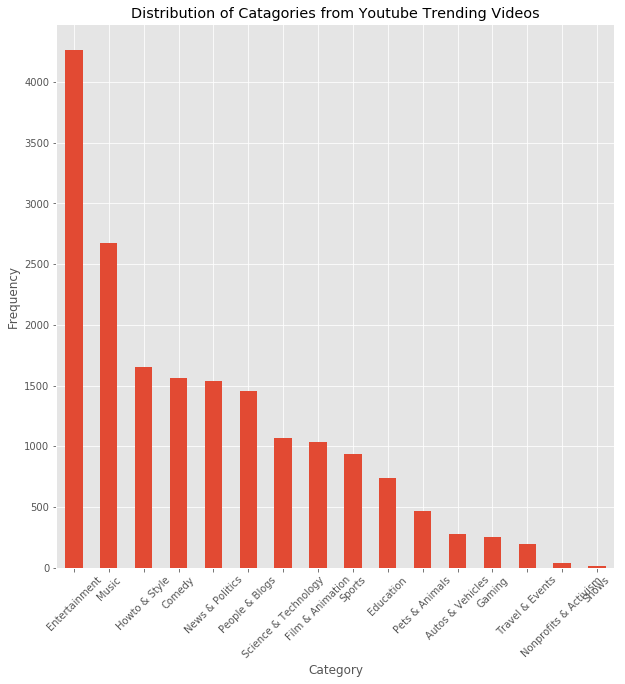

In [10]:
category_count = trending_df['category'].value_counts()
ax = category_count.plot.bar()
ax.set_xticklabels(labels=category_count.index, rotation=45, fontsize=10)
ax.set(xlabel='Category', ylabel='Frequency', 
       title='Distribution of Catagories from Youtube Trending Videos')
plt.savefig('../figures/dist_catagoies.png')

There are two catagories here that immediately stand out: entertainment and music. I was surprise that gaming got 3rd from last, considering it is a subgenre of our most popular catagory, entertainment.

### When are these Videos Published?

Might there be a sweet spot of publication hour that contribute to the most views?



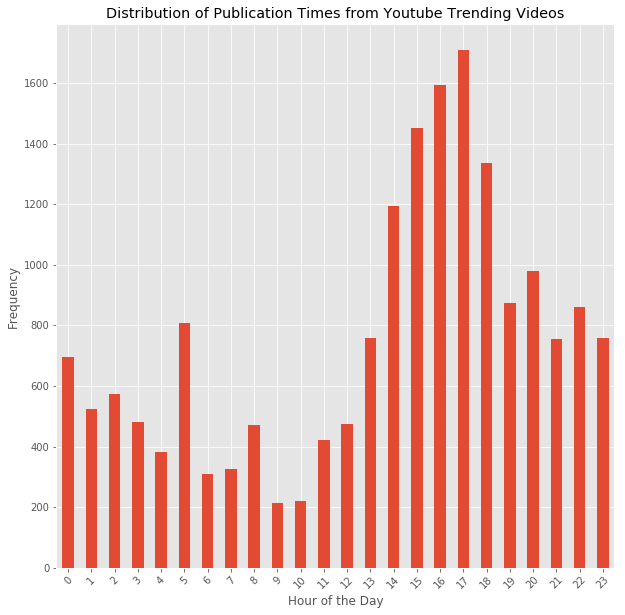

In [11]:
hour_pub_count = trending_df['publish_time'].dt.hour.value_counts()
ax = hour_pub_count.sort_index().plot.bar()
ax.set_xticklabels(labels=hour_pub_count.sort_index().index, rotation=45, fontsize=10)
ax.set(xlabel='Hour of the Day', ylabel='Frequency', 
       title='Distribution of Publication Times from Youtube Trending Videos')
plt.savefig('../figures/dist_publication.png')

As expected, pm hours make up the majority of the publication times with 5pm the most active hour for youtube publications. There an interesting spike at 5am, which I would guess might be due to scheduled automated uploads either by youtube or a consistanty popular third party(s).

### How much Time Passes between Published and Trending Videos?

Here we take a look at the difference between publication dates, and trending dates. There is a bit of bias here because youtubes trending algorithm changes over time, and so we should take the results with a grain of salt.

In [12]:
delta_pub_trend = (trending_df['trending_date'] - trending_df['publish_time']).dt.days
prob_day_i = {i: sum(delta_pub_trend == i)/len(delta_pub_trend) for i in range(16)}
total_prob = sum(prob_day_i.values())

pp = pprint.PrettyPrinter(indent=4)
print("Probability Given a Youtube Video Becomes Trending, The Probability of it will become Trending at Day i")
pp.pprint(prob_day_i)

print("{0:1.2f}% of all trending videos begin to trending before {1:1d} days of publication.".format(total_prob*100, len(prob_day_i)))

Probability Given a Youtube Video Becomes Trending, The Probability of it will become Trending at Day i
{   0: 0.10305931550566744,
    1: 0.1419610432485969,
    2: 0.15318586992406735,
    3: 0.15423131946737098,
    4: 0.15037966325519975,
    5: 0.12358314075052272,
    6: 0.076262793000990425,
    7: 0.031913722900847367,
    8: 0.014636293606250688,
    9: 0.0091339275888632117,
    10: 0.0064377682403433476,
    11: 0.0044569164740838564,
    12: 0.0017057334653901178,
    13: 0.00077033124243424669,
    14: 0.00033014196104324861,
    15: 0.00044018928139099813}
97.25% of all trending videos begin to trending before 16 days of publication.


Lets filter out outliers and then visualize these results with a histogram. From the distribution above, the results appear to be normal, so lets also try fitting a normal curve over this.

In [13]:
def filter_outliers(data, m=2):
    return list(filter(lambda x: abs(x - np.mean(data) < m * np.std(data)), data))

delta_pub_trend_clean = filter_outliers(delta_pub_trend, m=.1) # :(

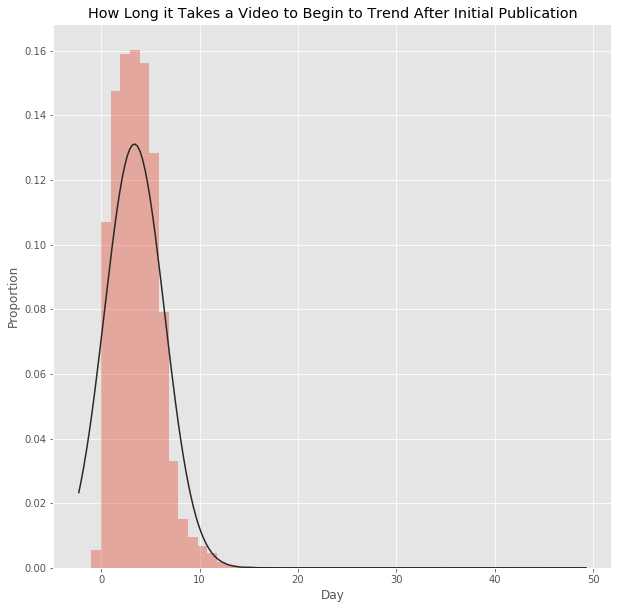

In [14]:
# now visualize the results
ax = sns.distplot(delta_pub_trend_clean, kde=False, fit=stats.norm)
ax.set(xlabel='Day', ylabel='Proportion', 
       title='How Long it Takes a Video to Begin to Trend After Initial Publication')
plt.savefig('../figures/dist_trend_pub_diff.png')

### Viewes by when a Trending Video Becomes Trending

My own suspecion is that the more time a youtube video is given before it hits trending, the more views it will obtain. This is where we get video gems such as 'Double Rainbow'.

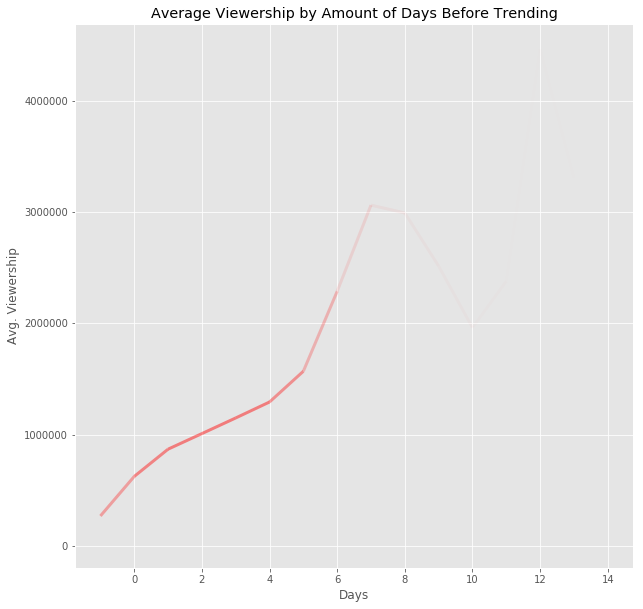

In [15]:
trending_df['delta_pub_trend_date'] = delta_pub_trend

# group the days before trending by group
delta_views = pd.DataFrame(trending_df.groupby('delta_pub_trend_date')['views'].mean())
delta_views.reset_index(level=0, inplace=True)

# alternative plots I've tried plotting
# ax = pd.rolling_mean(delta_views, 5).plot(style='k')
# ax = delta_views.plot(style='ro-')

# have the probability of a line segment coresponde to the probability of the data
subset_end = 16
delta_views_sub = delta_views.iloc[0:subset_end,:]

# multiple alpha by some constant here just to brighten the line
rbga_colors = [(1, 0, 0, min(alpha*3, 1)) for alpha in list(prob_day_i.values())]
lines = []
a, b = delta_views_sub['delta_pub_trend_date'], delta_views_sub['views']
for i in range(0, subset_end-1):
    lines.append([(a[i], b[i]), (a[i+1], b[i+1])])

lc = mc.LineCollection(lines, colors=rbga_colors, linewidths=3)
fig, ax = plt.subplots()
ax.add_collection(lc)
ax.autoscale()
ax.set(xlabel='Days', ylabel='Avg. Viewership', 
       title='Average Viewership by Amount of Days Before Trending')
plt.savefig('../figures/dist_views_by_delta_trend.png')

We can observe from this trend a positive coorelation between the number of days after a trending video has become published, and the average viewership of the video. The transparencies of each line segement scale with the probability of a trending video occuring at day i. The most transparent the line segment is, the less we should honor it. We can see that it almost falls to zero after 14 days.

### How Long do Trending Videos Typically Trend for?

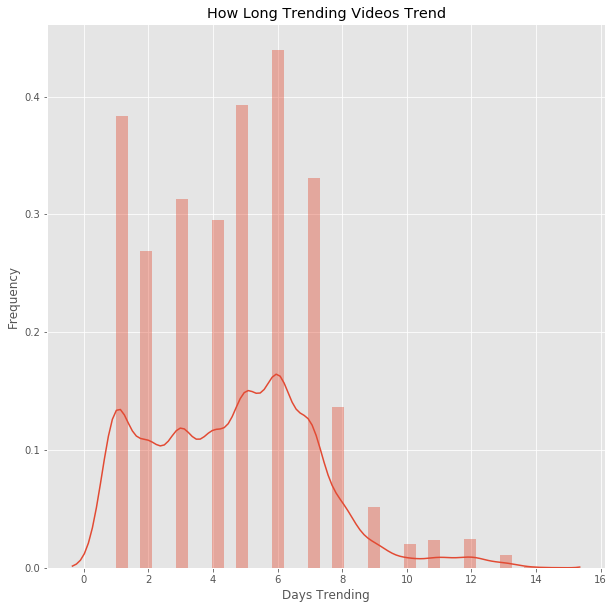

In [16]:
trending_freq = list(Counter(dup_trending_df['video_id']).values())
ax = sns.distplot(trending_freq)
ax.set(xlabel='Days Trending', ylabel='Frequency', 
       title='How Long Trending Videos Trend')
plt.savefig('../figures/dist_days_trending.png')

### Are Video Publications Significantly Different by Week?

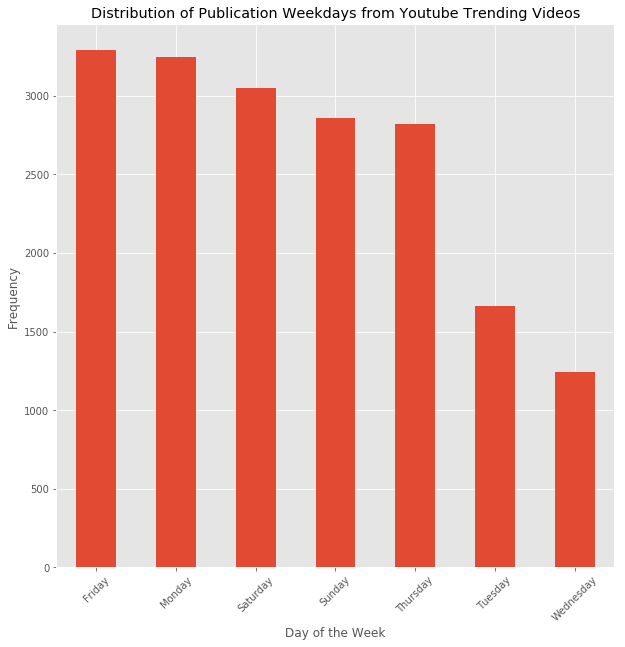

In [17]:
weekday_map = dict(enumerate(calendar.day_name))
weekday_pubs = [weekday_map[day] for day in trending_df['publish_time'].dt.weekday]
pub_weekday_hist = pd.Series(weekday_pubs).value_counts()

ax = pub_weekday_hist.plot.bar()
ax.set_xticklabels(labels=pub_weekday_hist.sort_index().index, rotation=45, fontsize=10)
ax.set(xlabel='Day of the Week', ylabel='Frequency', 
       title='Distribution of Publication Weekdays from Youtube Trending Videos')
plt.savefig('../figures/dist_pub_by_week.png')

Friday and Monday stand out as the two most popular days, Over all there seems to be significant differences in the frequencies by the day of week. I expected to see a more uniform distribution.

Could this distribution be inline with the generally when people watch the most youtube? That is to say, could the days where most trending videos come to be also be inline with the days when people generally watch the most youtube?

### Views by Weekday

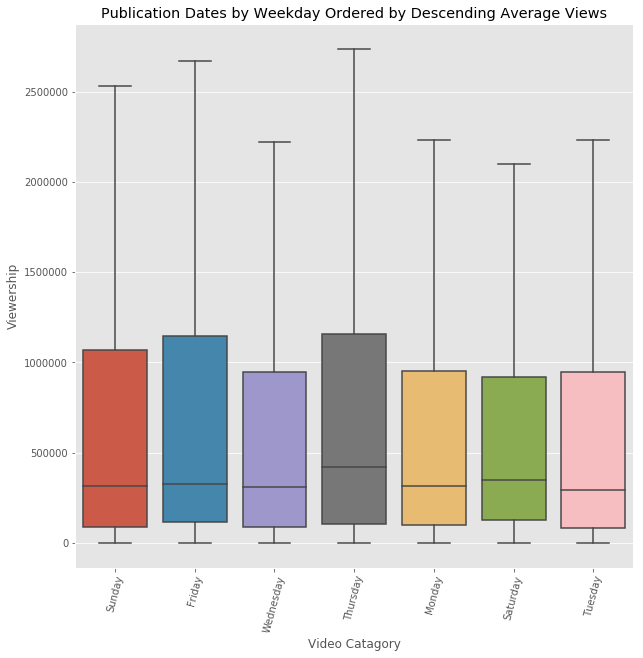

In [18]:
trending_df['publish_day'] = weekday_pubs

# we are interested in discovering whether viewership by week day related publication dates
# lets reverse to get descending order as to minic the barplot above
ranks = trending_df.groupby('publish_day')['views'].mean().sort_values().index[::-1]
ax = sns.boxplot(x="publish_day", y="views", data=trending_df, showfliers=False, order=ranks)
ax.set_xticklabels(ax.get_xticklabels(), rotation=75)
ax.set(xlabel='Video Catagory', ylabel='Viewership', 
       title='Publication Dates by Weekday Ordered by Descending Average Views')
plt.savefig('../figures/box_views_by_week.png')

Ok that is interesting. The plot above suggests that viewership is fairly consistant throughout the week. So if viewership is consistant throughout the week, but trending videos differ by the day of week, this suggests that there is some intentional effort made in successful trending videos to publish at a certain day of the week.

First lets confirm that the average viewership is indeed not different by the day of the week through ANOVA hypothesis testing.

In [19]:
weekday_grps = trending_df.groupby('publish_day')
F, p = stats.f_oneway(weekday_grps.get_group('Monday')['views'],
                      weekday_grps.get_group('Tuesday')['views'],
                      weekday_grps.get_group('Wednesday')['views'],
                      weekday_grps.get_group('Thursday')['views'],
                      weekday_grps.get_group('Friday')['views'],
                      weekday_grps.get_group('Saturday')['views'],
                      weekday_grps.get_group('Sunday')['views'])

print('F: ', F)
print('p: ', p)

F:  9.26050657996
p:  3.70050709202e-10


Our intuition was incorrect. Under any reasonable alpha, we reject the null hypothesis which claims that each day of the week has the same true average amount of views.

## Viewership

Questions that pertain to the popularity of videos.

---

### How does each type of Video Catagory Contribute to Viewership?

Among trending videos, which catagories capture the most attention of the market?


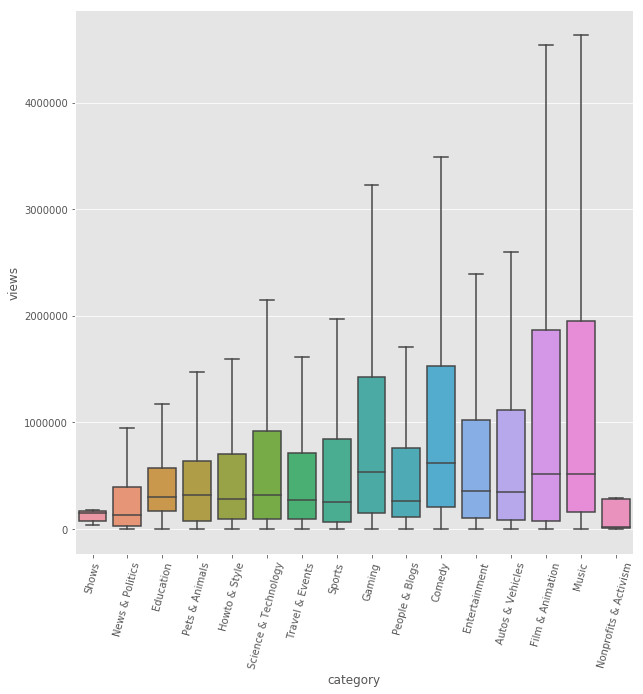

In [20]:
# rank the boxplot by ascending mean for better viewing
ranks = trending_df.groupby('category')['views'].mean().sort_values().index
view_by_cat = sns.boxplot(x="category", y="views", data=trending_df, showfliers=False, order=ranks)
view_by_cat.set_xticklabels(view_by_cat.get_xticklabels(), rotation=75)
ax.set(xlabel='Video Catagory', ylabel='Viewership', 
       title='Boxplot for each Youtube Video Category Ordered by Acending Average Views')
plt.savefig('../figures/box_views_by_cat.png')

### Which Channels Trend Most Frequently?



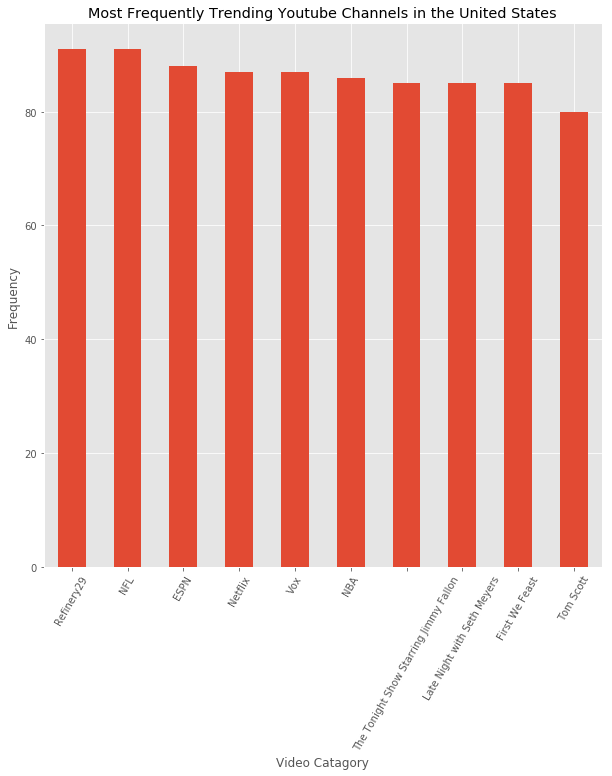

In [21]:
channel_count = trending_df['channel_title'].value_counts().head(10)
ax = channel_count.plot.bar()
ax.set_xticklabels(labels=channel_count.index, rotation=60, fontsize=10)
ax.set(xlabel='Video Catagory', ylabel='Frequency', 
       title='Most Frequently Trending Youtube Channels in the United States')
plt.savefig('../figures/dist_freq_trend.png')

### What Tags do Trending Videos Undertake?

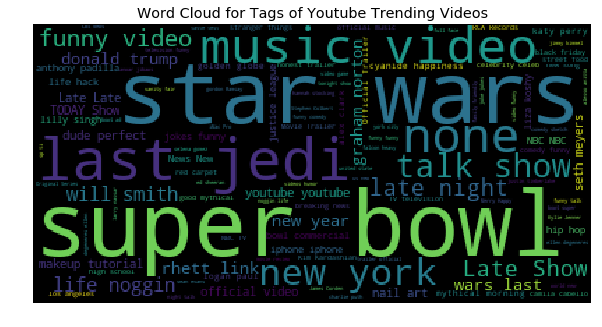

In [22]:
all_tags = ' '.join(trending_df['tags'])
wc = WordCloud(background_color = 'black', max_words = 1000, stopwords = STOPWORDS)
wc.generate(all_tags)
plt.imshow(wc)
plt.axis('off')
plt.title('Word Cloud for Tags of Youtube Trending Videos')
plt.savefig('../figures/wc_tags.png')

### What about Titles?

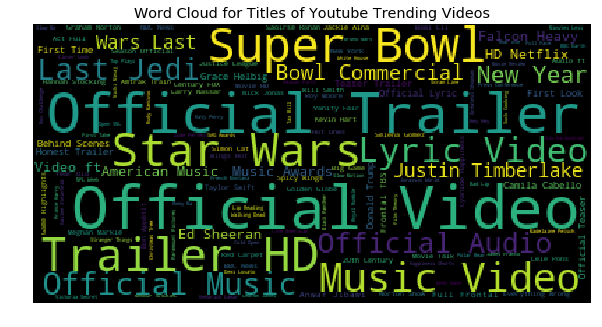

In [23]:
all_titles = ' '.join(trending_df['title'])
wc = WordCloud(background_color = 'black', max_words = 1000, stopwords = STOPWORDS)
wc.generate(all_titles)
plt.imshow(wc)
plt.axis('off')
plt.title('Word Cloud for Titles of Youtube Trending Videos')
plt.savefig('../figures/wc_titles.png')

### What 'Things' do Trending Descriptions Include?

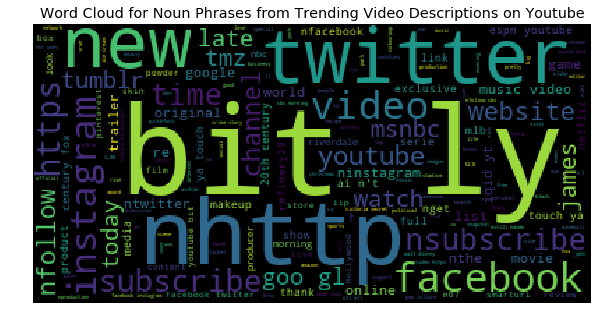

In [24]:
# noun extraction takes some heavy processing so were going to first randomly sample 1000 trending videos
random.seed(42)
rand_trend_df = trending_df.sample(n=250)

all_descriptions = ' '.join(rand_trend_df['description'])
description_blob = TextBlob(all_descriptions)
wc = WordCloud(background_color = 'black', max_words = 1000, stopwords = STOPWORDS)
wc.generate(' '.join(description_blob.noun_phrases))
plt.imshow(wc)
plt.axis('off')
plt.title('Word Cloud for Noun Phrases from Trending Video Descriptions on Youtube')
plt.savefig('../figures/wc_description_nouns.png')

**Trending videos**

* include a lot of links to social media
* thank their viewers for watching
* remind their viewers to subscribe
* use the word 'new' alot

## Sentiment Analysis

How do people feel when they watch a viral video? Which emotions are more dominant in particular?

---


In [26]:
# our dataset
file_path = '../data/youtube_comments/2018-02-21-02h-23m YT comments.csv'
comment_df = pd.read_csv(file_path)
comment_df['comment_reply'] = comment_df['comment_reply'].astype(str)
comment_df.head()

,video_id,comment_id,comment_publish_date,commenter_url,comment_reply,viewer_rating,like_count
0,2kyS6SvSYSE,Ugwo_tq1Re5m5z3GGUt4AaABAg,2018-02-20T15:13:40.000Z,http://www.youtube.com/channel/UCrtRtfypQ55Rt-...,"That ""art"" is like a toddlers scribble !!!! W...",none,0.0
1,2kyS6SvSYSE,Ugw6lLf1YMBpc0F_s-94AaABAg,2018-02-20T05:31:53.000Z,http://www.youtube.com/channel/UCfQzKdYBF53ik4...,How about Bringing Back the Q&A segment you us...,none,0.0
2,2kyS6SvSYSE,Ugz1TqUqDZuqAt8kSJx4AaABAg,2018-02-17T00:39:26.000Z,http://www.youtube.com/channel/UCUSnSQiRA3hy4g...,Omg I'd love thattt,none,0.0
3,2kyS6SvSYSE,UgwTd1n3oqY7dDea0Th4AaABAg,2018-02-15T02:13:14.000Z,http://www.youtube.com/channel/UC6ZDNsfpQ4UNbp...,+GaryVee said you would absolutely crush a pod...,none,0.0
4,2kyS6SvSYSE,Ugwu2_6NhRxZ1KFKQwp4AaABAg,2018-02-15T01:01:47.000Z,http://www.youtube.com/channel/UC5nB4nvDDhTPyI...,Do it!,none,0.0


### Clean the Data

In [27]:
# some comments are gibberish. Because we have a lot of comments to work with, else only accept
# comments that acii values that are between 0 and 127 -> http://www.asciitable.com/
def within_ascii(low, high, s):
    return all(low <= ord(char) <= high for char in s)

# bar = progressbar.ProgressBar()
# is_within_ascii = [within_ascii(0, 127, comment) for comment in bar(comment_df['comment_reply'])]

# comment_df = comment_df[is_within_ascii]
# print('Removed:', sum(is_within_ascii)/len(is_within_ascii), 'of comments')

In [28]:
# randomly sample from this large dataset
rand_comment_df = comment_df.sample(n=1000)

# lets add two new columns to this dataframe: one for the polarity of the comment, and another for subjectivity
bar = progressbar.ProgressBar()
polarity_score, subjectivity_score = [], []
for comment in bar(rand_comment_df['comment_reply']):
    tmp_blob = TextBlob(comment)
    polarity_score.append(tmp_blob.sentiment.polarity)
    subjectivity_score.append(tmp_blob.sentiment.subjectivity)

rand_comment_df['polarity_score'] = polarity_score
rand_comment_df['subjectivity_score'] = subjectivity_score

100% (1000 of 1000) |#####################| Elapsed Time: 0:00:00 Time: 0:00:00


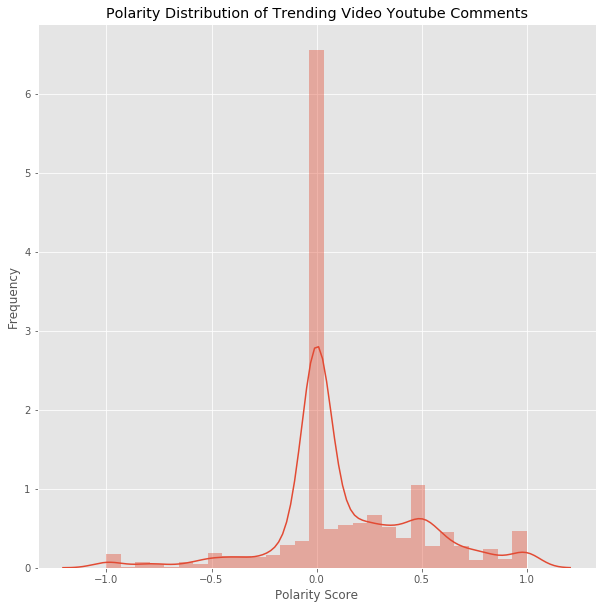

In [29]:
# visualize polarity and subjectivity density plots
ax = sns.distplot(rand_comment_df['polarity_score'])
ax.set(xlabel='Polarity Score', ylabel='Frequency', 
       title='Polarity Distribution of Trending Video Youtube Comments')
plt.savefig('../figures/density_comment_polarity.png')

It looks like more comments for trending videos are more positive than they are negative.

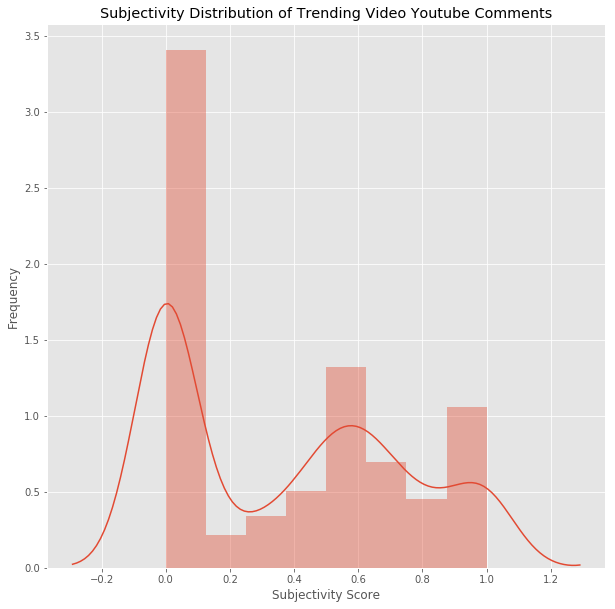

In [30]:
ax = sns.distplot(rand_comment_df['subjectivity_score'])
ax.set(xlabel='Subjectivity Score', ylabel='Frequency', 
       title='Subjectivity Distribution of Trending Video Youtube Comments')
plt.savefig('../figures/density_comment_subjectivity.png')

Subjectivity and objectivity in comments seem to be equally distributed. Unfortunately as of yet, the youtube api does not provide information on whether a user has downvoted a video. In future, however, youtube has plans to implement this change.

Once this change is put in place, another option would be to build a Naive Bayes Classifier with comments labeled as either positive or negative on the basis of their rating of the video (if at all). 

## Modeling

---

### Coorelation Analysis

How do `views`, `likes`, `dislikes`, `comment_count`, and `n_tags` coorelate with one another? For example, does the amount of comments coorelate well with the number of views? Can the amount of dislikes be a strong predictor to the amount of comments generated?

#### Scatter Plot Matrix (Pair-wise plotting)

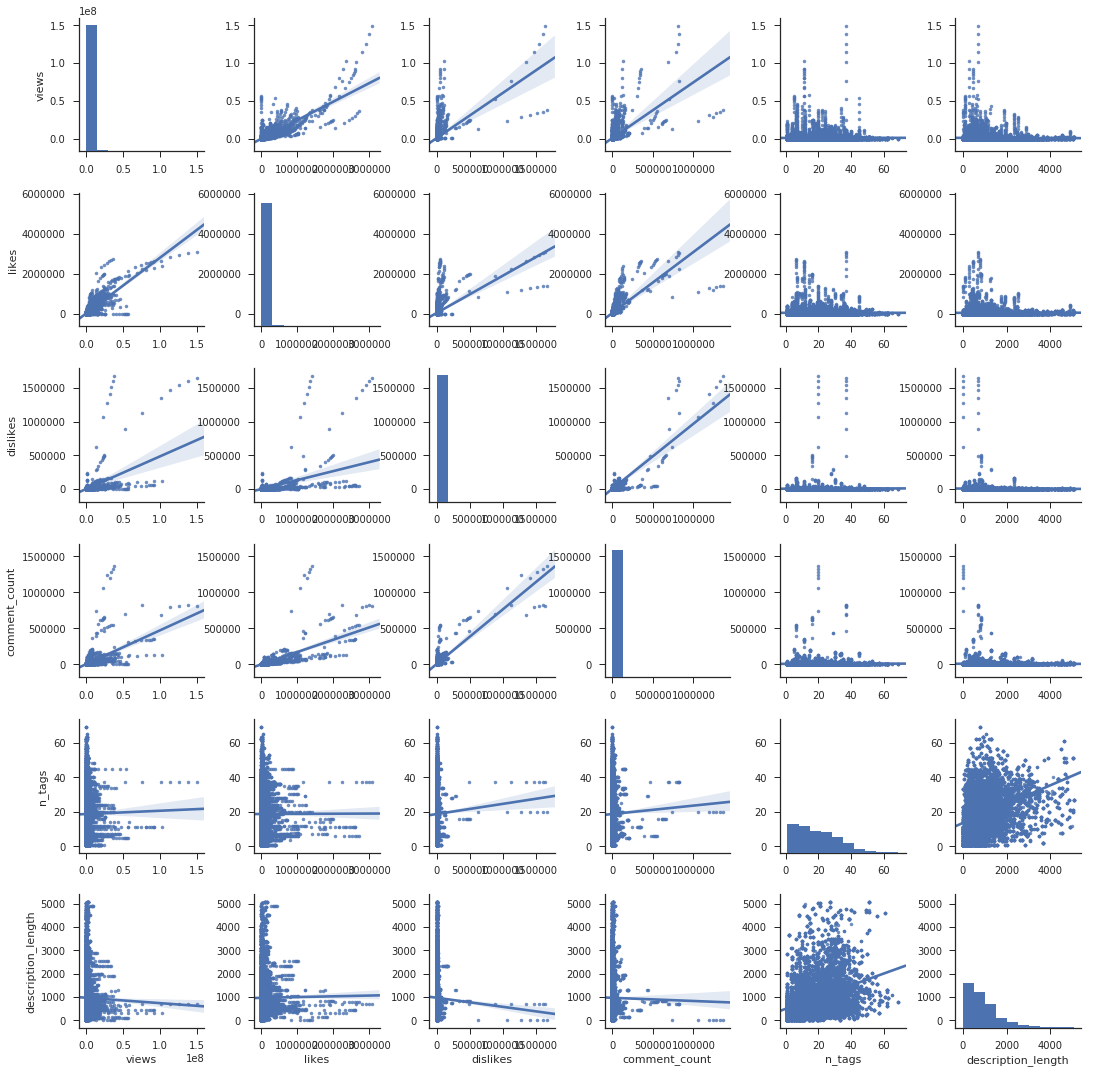

In [31]:
# adding a couple more possiblity insightly stats
trending_df['description_length'] = [len(desc) for desc in trending_df['description']]

interests = ['views', 'likes', 'dislikes', 'comment_count', 'n_tags', 'description_length']
sns.set(style='ticks')
sns.pairplot(trending_df[interests], kind='reg', markers='.', dropna=True)
plt.savefig('../figures/scatter_matrix.png')

#### Coorelation Matrix

What is the coorelational strength between each?

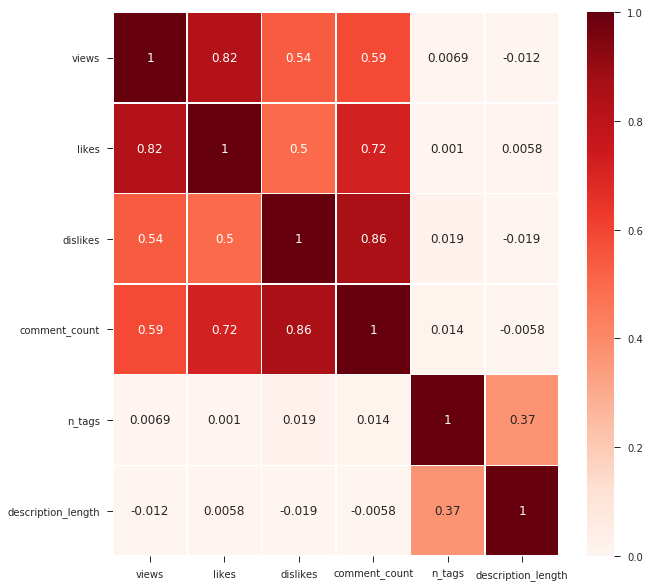

In [32]:
# we need to specify which columns we are interested in the data frame
corr_matrix = trending_df[interests].corr()

# plot the results with a linear interpolation color map
heatmap = sns.heatmap(corr_matrix, linewidths=.5, annot=True, vmin=0, vmax=1, cmap='Reds')
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation = 0)
plt.savefig('../figures/correlation_matrix.png')

**Summary:**

* High Correlation - Views and Likes, Comment_count and Dislikes
* Medium Correlation - Views and Dislikes, Views and Comment_Count, Likes and Comment_Count
* Low Correlation - Likes and Dislike, number of tags and description length

One thing that we can immediately notice is that the number of tag has virtually no connection to any other meta factor. One of the strongest predictors for views is the number of likes (naturally).

Another interesting fact is that the number comments is both coorelated with the number of likes and dislikes, but is more strongly coorelated with the number of dislikes. We can speculate here that heated discussions spark more interaction and debates among viewers.

### What is the Best Multilinear Predictor?

Here we will develope a multilinear regression model for trending youtube video views. We can use as a predictor for the amount of views a trending video will get.

$$
\text{Views} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots +  \beta_n x_n
$$

 
where $x_i$ are predictive variables.

In [33]:
# lets look at all combinations of prediction variable, and select the best one for our model
# note: to obtain a full list of the parameters you wish to extract, run dir(results)

bar = progressbar.ProgressBar()
best_r2, best_model, best_predictors = -1, 0, ''
for i in bar(range(1, len(interests) - 1)):
    for combo in combinations(interests[1:], i):
        predictors = 'views ~ ' + ' + '.join(combo)
        results = sm.ols(predictors, data=trending_df).fit()
        if best_r2 < results.rsquared_adj:
            best_model = results
            best_predictors = predictors

print(best_predictors)
print(best_model.params)
best_model.summary()

100% (4 of 4) |###########################| Elapsed Time: 0:00:00 Time: 0:00:00


views ~ dislikes + comment_count + n_tags + description_length
Intercept             925103.932721
dislikes                  13.722464
comment_count             60.370738
n_tags                   156.131668
description_length       -39.174878
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  views   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.351
Method:                 Least Squares   F-statistic:                     2462.
Date:                Sun, 25 Feb 2018   Prob (F-statistic):               0.00
Time:                        19:51:20   Log-Likelihood:            -3.0003e+05
No. Observations:               18174   AIC:                         6.001e+05
Df Residuals:                   18169   BIC:                         6.001e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           9.251e+05   5.13e+04     18.017      0.000    8.24e+05    1.03e+06
dislikes              13.7225      1.286     10.674      0.000      11.203      16.242
comment_count         60.3707      1.454     41.517      0.000      57.521      63.221
n_tags               156.1317   2321.440      0.067      0.946   -4394.110    4706.373
description_length   -39.1749     34.154     -1.147      0.251    -106.120      27.770
==============================================================================
Omnibus:                    24923.082   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         25186805.014
Skew:                           7.400   Prob(JB):                         0.00
Kurtosis:                     184.774   Cond. No.                     1.01e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.01e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""